# **Statistics(I)(2) - Final Project Code**
## **Descriptive Statistics Part**

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from scipy import stats
import seaborn as sns
import math

In [23]:
def chi_square_normality_test(data, bin_edges=None):
    """
    Perform Chi-Square Normality Test using user-defined bins.
    
    Parameters:
    - data: array-like, the input data
    - bin_edges: list or array of bin edges (must be strictly increasing)
    
    Returns:
    - chi2_stat: Chi-square statistic
    - p_value: p-value
    - df: degrees of freedom
    - observed: observed frequencies
    - expected: expected frequencies
    - used_bin_edges: bin edges actually used (after merging if any)
    """
    data = np.asarray(data)
    n = len(data)
    
    # Estimate normal parameters
    mu = np.mean(data)
    sigma = np.std(data, ddof=1)

    if bin_edges is None:
        raise ValueError("You must provide bin_edges as a list or array.")
    
    bin_edges = np.array(bin_edges)
    if not np.all(np.diff(bin_edges) > 0):
        raise ValueError("Bin edges must be strictly increasing.")

    # Calculate observed frequencies
    observed, _ = np.histogram(data, bins=bin_edges)

    # Calculate expected frequencies from normal CDF
    expected_probs = np.diff(stats.norm.cdf(bin_edges, loc=mu, scale=sigma))
    expected = expected_probs * n

    # Merge bins with expected < 5 from left
    obs = observed.tolist()
    exp = expected.tolist()
    edges = bin_edges.tolist()
    
    i = 0
    while i < len(exp) and exp[i] < 5:
        exp[i+1] += exp[i]
        obs[i+1] += obs[i]
        del exp[i]
        del obs[i]
        del edges[i+1]  # remove the right edge of merged bin

    # Merge bins with expected < 5 from right
    i = len(exp) - 1
    while i >= 0 and exp[i] < 5:
        exp[i-1] += exp[i]
        obs[i-1] += obs[i]
        del exp[i]
        del obs[i]
        del edges[i]  # remove the left edge of merged bin
        i -= 1

    if len(exp) < 4:
        raise ValueError("Not enough valid bins after merging. Try fewer or wider bins.")

    # Compute chi-square statistic
    chi2_stat = np.sum((np.array(obs) - np.array(exp)) ** 2 / np.array(exp))
    df = len(exp) - 3  # -2 for estimated \mu and \sigma, -1 for constraint
    p_value = stats.chi2.sf(chi2_stat, df)

    return chi2_stat, p_value, df, obs, exp, edges


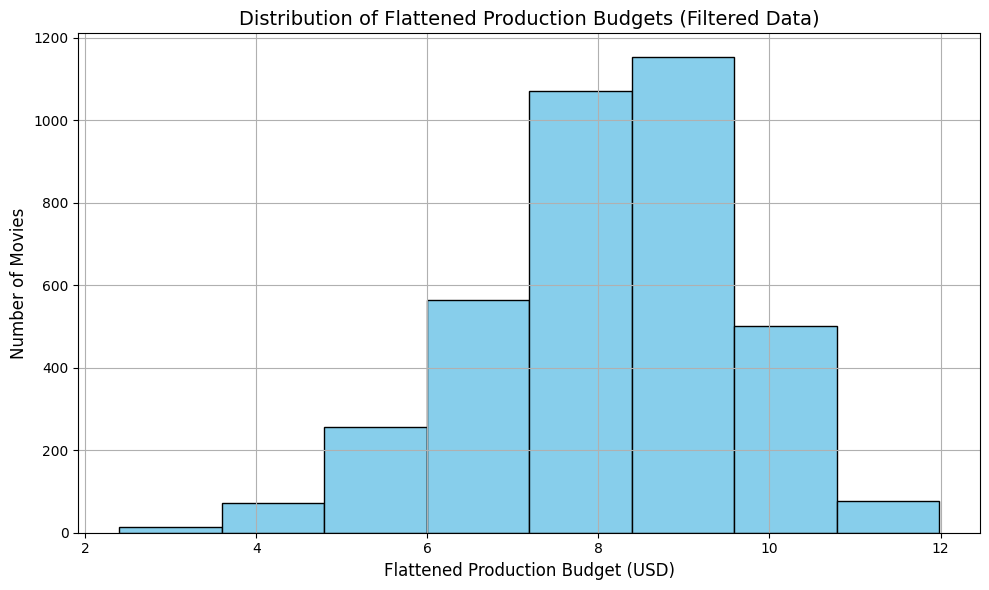

In [24]:
df = pd.read_csv("movie_summary.csv")

filtered_df = df[
    (df['production_budget'] != 0) &
    (df['production_year'] > 2000) &
    df['genre'].notna() &
    df['domestic_box_office'].notna() &
    df['international_box_office'].notna()
].copy()

filtered_df["total_box_office"] = filtered_df["domestic_box_office"] + filtered_df["international_box_office"]
filtered_df["flattened_production_budget"] = np.pow(filtered_df["production_budget"], 1/8)
filtered_df["flattened_total_box_office"] = np.pow(filtered_df["total_box_office"], 1/8)

plt.figure(figsize=(10, 6))
plt.hist(filtered_df['flattened_production_budget'], bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Flattened Production Budgets (Filtered Data)', fontsize=14)
plt.xlabel('Flattened Production Budget (USD)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

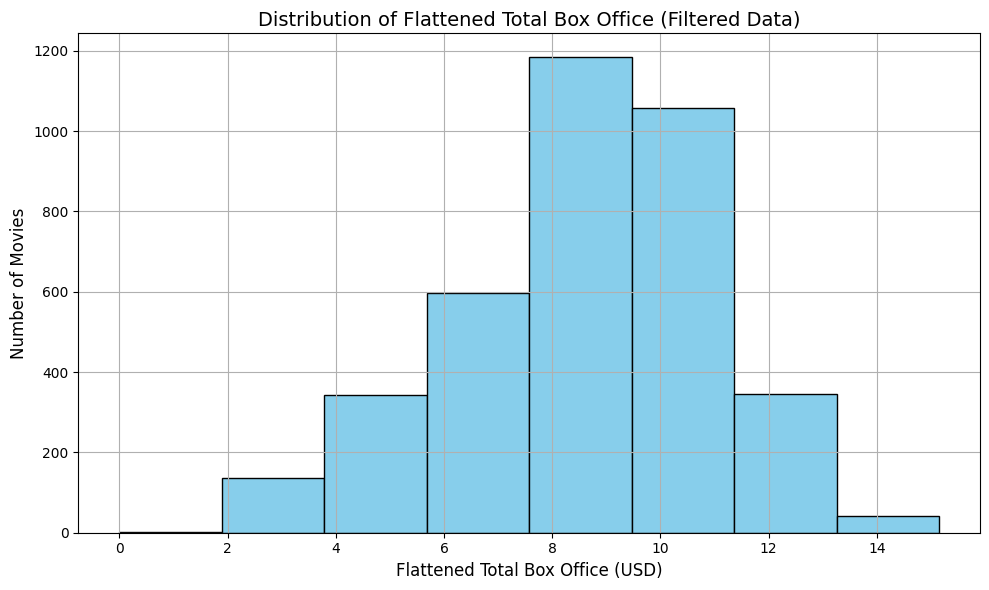

In [25]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['flattened_total_box_office'], bins=8, color='skyblue', edgecolor='black')
plt.title('Distribution of Flattened Total Box Office (Filtered Data)', fontsize=14)
plt.xlabel('Flattened Total Box Office (USD)', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

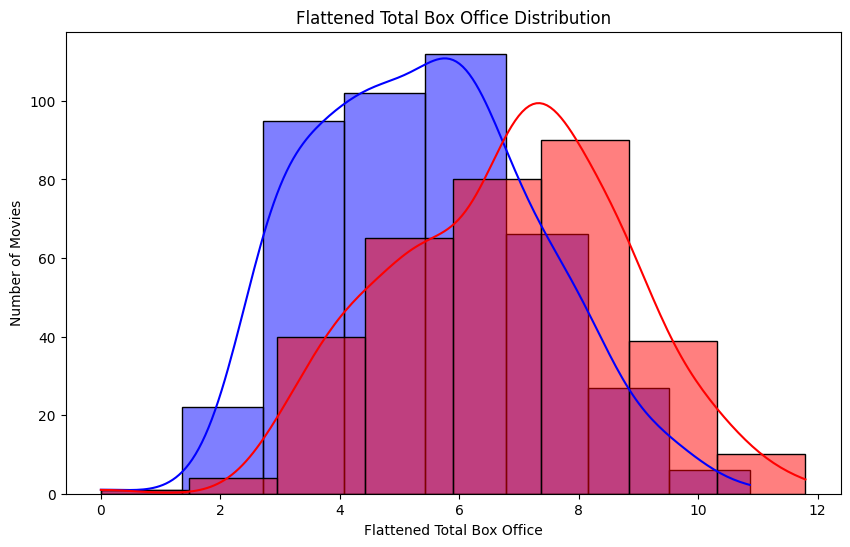

"Low Budget" Sample Size ：431
"High Budget" Sample Size：329


In [26]:
filtered_df['budget_category'] = pd.cut(
    filtered_df['production_budget'], 
    bins=[0, 2000000, 5000000], 
    labels=['Low', 'High']
)

budget_low = filtered_df[filtered_df['budget_category'] == 'Low']['flattened_total_box_office']
budget_high = filtered_df[filtered_df['budget_category'] == 'High']['flattened_total_box_office']

plt.figure(figsize=(10, 6))
sns.histplot(budget_low, bins=8, kde=True, color='blue')
sns.histplot(budget_high, bins=8, kde=True, color='red')
plt.title('Flattened Total Box Office Distribution')
plt.xlabel('Flattened Total Box Office')
plt.ylabel('Number of Movies')
plt.show()

print(f"\"Low Budget\" Sample Size ：{len(budget_low)}")
print(f"\"High Budget\" Sample Size：{len(budget_high)}")

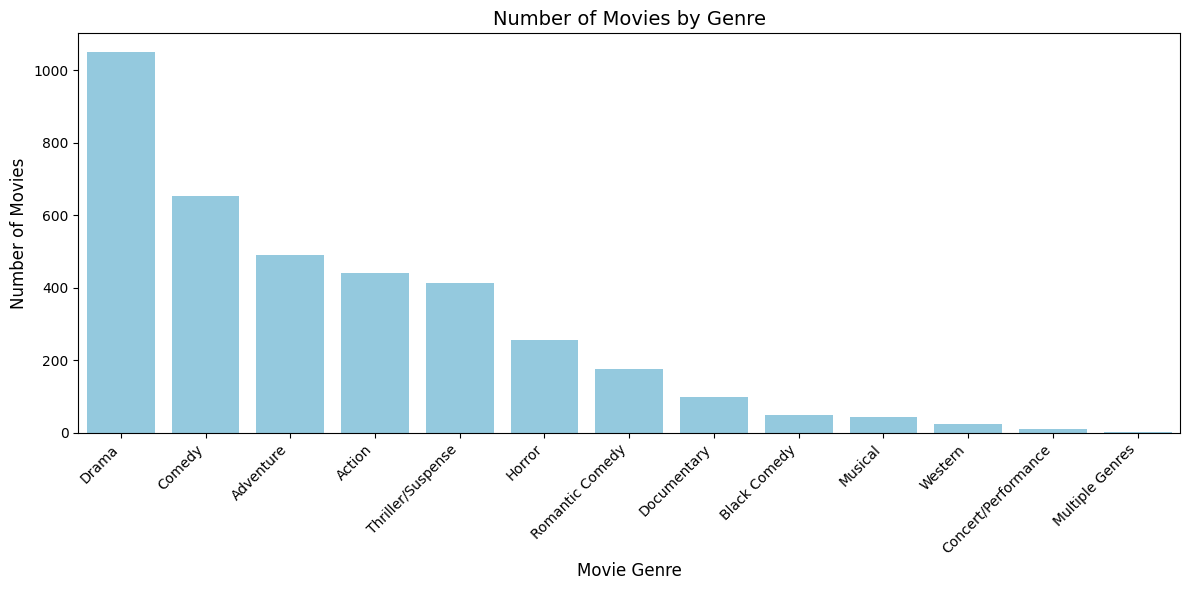

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='genre', order=filtered_df['genre'].value_counts().index, color='skyblue')

plt.title('Number of Movies by Genre', fontsize=14)
plt.xlabel('Movie Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

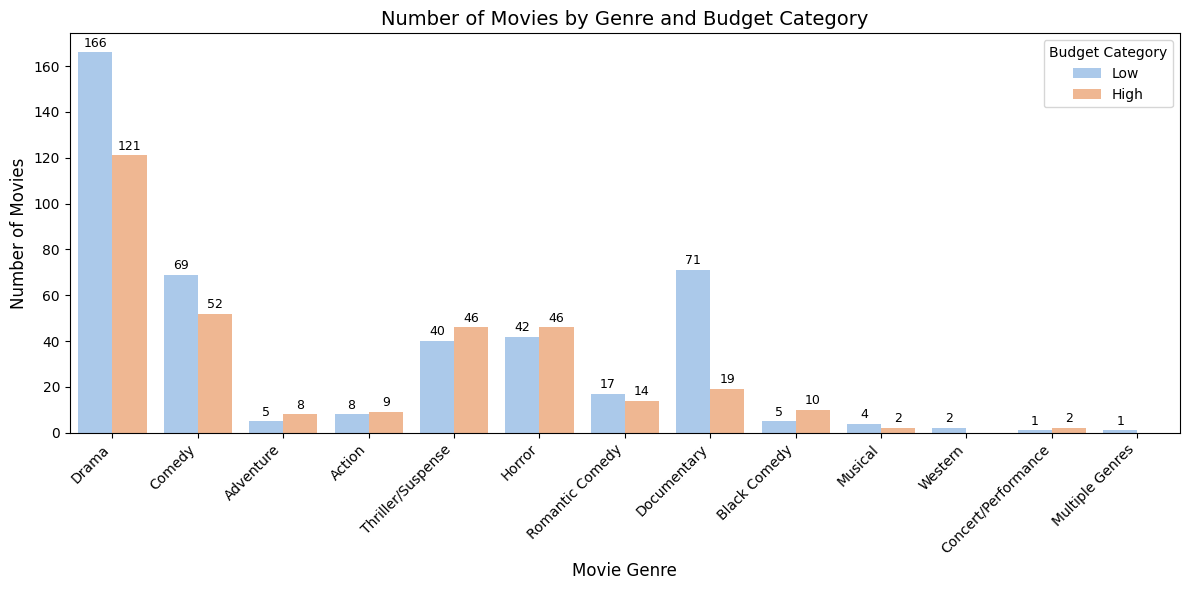

In [28]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=filtered_df,
    x='genre',
    hue='budget_category',
    order=filtered_df['genre'].value_counts().index,
    palette='pastel'
)

plt.title('Number of Movies by Genre and Budget Category', fontsize=14)
plt.xlabel('Movie Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Budget Category')

for p in ax.patches:
    height = int(p.get_height())
    if height > 0:
        ax.annotate(
            str(height),
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=9,
            xytext=(0, 2),
            textcoords='offset points'
        )

plt.tight_layout()
plt.show()